In [3]:
import sys ,os, json
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)
import configparser
import pydicom
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import utils as Utils
from importlib import reload
reload(Utils)

config = configparser.ConfigParser()
config.read("../../config.ini")

pd.set_option('display.max_colwidth', None)

# Initial Analisys

In [4]:
MIDRC_RICORD_1A_PATH = config['PATHS']['MIDRC_RICORD_1A_PATH']
MIDRC_RICORD_1A_CLINICAL_METADATA_PATH = os.path.join(MIDRC_RICORD_1A_PATH, "MIDRC-RICORD-1a Clinical Data Jan 13 2021.xlsx")
MIDRC_RICORD_1A_METADATA_PATH = os.path.join(MIDRC_RICORD_1A_PATH, "manifest-1608266677008", "metadata.csv")
MIDRC_RICORD_ANNOTATIONS_PATH = os.path.join(MIDRC_RICORD_1A_PATH, "MIDRC-RICORD-1a_annotations_labelgroup_all_2020-Dec-8.json")
MIDRC_RICORD_RAW_FOLDERS_PATH = os.path.join(MIDRC_RICORD_1A_PATH, "manifest-1608266677008", "MIDRC-RICORD-1A")
PROCESSED_DATA_PATH = config["PATHS"]["PROCESSED_DATA_PATH"]

print(MIDRC_RICORD_1A_PATH)
print(MIDRC_RICORD_1A_CLINICAL_METADATA_PATH)
print(MIDRC_RICORD_RAW_FOLDERS_PATH)

/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/MIDRC_RICORD_1A
/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/MIDRC_RICORD_1A/MIDRC-RICORD-1a Clinical Data Jan 13 2021.xlsx
/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/MIDRC_RICORD_1A/manifest-1608266677008/MIDRC-RICORD-1A


In [9]:
clinical_metadata_df = pd.read_excel(MIDRC_RICORD_1A_CLINICAL_METADATA_PATH)
print(clinical_metadata_df.shape)
print(clinical_metadata_df["Anon MRN"].nunique())
print(clinical_metadata_df["Anon Study UID"].nunique())
#Group by Anon MRN and compute the number of distinct Anon Study UID. Order decreasingly
print(clinical_metadata_df.groupby("Anon MRN")["Anon Study UID"].nunique().sort_values(ascending=False)[:10])
clinical_metadata_df[clinical_metadata_df["Anon MRN"].isin(["40808-000012", "440808-000008","SITE2-000245","440808-000007","440808-000010","SITE2-000236","440808-000011","440808-000005"])].head(10)

(120, 10)
110
120
Anon MRN
440808-000012    3
440808-000008    3
SITE2-000245     2
440808-000007    2
440808-000010    2
SITE2-000236     2
440808-000011    2
440808-000005    2
SITE2-000065     1
SITE2-000099     1
Name: Anon Study UID, dtype: int64


,Anon MRN,Anon Age,AnonTCIA Study Date,Anon Exam Description,Anon Sex,Anon Study UID,Anon Image Count,Modality,Result,Specimen Source
19,440808-000005,60.0,2004-11-19,THORAX/ABDOMEN/PELVIS + CONT,M,1.2.826.0.1.3680043.10.474.440808.2558,84,CT,DETECTED,RT-PCR
20,440808-000005,60.0,2004-12-03,THORAX PE,M,1.2.826.0.1.3680043.10.474.440808.3022,111,CT,DETECTED,RT-PCR
22,440808-000007,55.0,2007-05-25,THORAX/ABDOMEN/PELVIS + CONT,F,1.2.826.0.1.3680043.10.474.440808.2451,104,CT,DETECTED,RT-PCR
23,440808-000007,55.0,2007-05-09,CARDIAC CORONARY CTA,F,1.2.826.0.1.3680043.10.474.440808.652,155,CT,DETECTED,RT-PCR
24,440808-000008,65.0,2006-03-11,THORAX PE,M,1.2.826.0.1.3680043.10.474.440808.1352,94,CT,DETECTED,RT-PCR
25,440808-000008,65.0,2006-03-22,THORAX PE + LOW DOSE,M,1.2.826.0.1.3680043.10.474.440808.2746,90,CT,DETECTED,RT-PCR
26,440808-000008,65.0,2006-04-01,THORAX + CONT,M,1.2.826.0.1.3680043.10.474.440808.2923,96,CT,DETECTED,RT-PCR
28,440808-000010,55.0,2003-02-09,THORAX PE,F,1.2.826.0.1.3680043.10.474.440808.2339,109,CT,DETECTED,RT-PCR
29,440808-000010,55.0,2003-02-21,THORAX PE,F,1.2.826.0.1.3680043.10.474.440808.2645,98,CT,DETECTED,RT-PCR
30,440808-000011,65.0,2002-07-04,THORAX LOW DOSE,M,1.2.826.0.1.3680043.10.474.440808.1895,94,CT,DETECTED,RT-PCR


In [16]:
downloaded_metadata_df = pd.read_csv(MIDRC_RICORD_1A_METADATA_PATH)
print(downloaded_metadata_df.shape)
print(f"Nº of folders in MIDRC-RICORD-1a parent folder {len(os.listdir(MIDRC_RICORD_RAW_FOLDERS_PATH))}")
print(downloaded_metadata_df["Study UID"].nunique())
print(downloaded_metadata_df["File Location"].nunique())
print(downloaded_metadata_df["Series UID"].nunique())
downloaded_metadata_df.head(1)

(229, 17)
Nº of folders in MIDRC-RICORD-1a parent folder 111
120
229
229


,Series UID,Collection,3rd Party Analysis,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp
0,1.2.826.0.1.3680043.10.474.419639.219217537435007492574794997846,MIDRC-RICORD-1A,NO,https://doi.org/10.7937/VTW4X588,MIDRC-RICORD-1A-419639-000082,1.2.826.0.1.3680043.10.474.419639.312580455409613733097488204614,CT CHEST WITHOUT CONTRAST,08-02-2002,SCOUT CHEST,NaN,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,2,944.21 KB,./MIDRC-RICORD-1A/MIDRC-RICORD-1A-419639-000082/08-02-2002-NA-CT CHEST WITHOUT CONTRAST-04614/1.000000-SCOUT CHEST-97846,2023-04-06T14:47:03.707


The page says 120 studies and 120 patients, however there are only 110 folders

In [89]:
metadata_raw_df = (
    clinical_metadata_df[["Anon Exam Description", "Anon Study UID", "Result"]]
    .rename(columns={"Anon Study UID":"Study UID"})
    .merge(
        downloaded_metadata_df[["Series UID", "Study UID","" "Number of Images", "File Location"]],
        on="Study UID",
    )
)

metadata_raw_folder_paths_df = (
    metadata_raw_df
    .assign(
        FolderPath=metadata_raw_df["File Location"]
        .apply(lambda x: MIDRC_RICORD_1A_PATH + "/manifest-1608266677008" + x.split(".",1)[1])
    )
)
metadata_df = (
    metadata_raw_folder_paths_df
    .assign(
        FilePaths=metadata_raw_folder_paths_df["FolderPath"]
        .apply(lambda x: [os.path.join(x, file) for file in os.listdir(x)])
    )
    .explode("FilePaths")
    .rename(columns={"Study UID":"StudyInstanceUID", "Series UID":"SeriesInstanceUID"})
)
print(metadata_df.shape)
print(f"Distinct StudyInstanceUID: {metadata_df['StudyInstanceUID'].nunique()}")
print(f"Distinct SeriesInstanceUID: {metadata_df['SeriesInstanceUID'].nunique()}")
metadata_df.head(3)


(31856, 8)
Distinct StudyInstanceUID: 120
Distinct SeriesInstanceUID: 229


,Anon Exam Description,StudyInstanceUID,Result,SeriesInstanceUID,Number of Images,File Location,FolderPath,FilePaths
0,CT CHEST WITHOUT CONTRAST,1.2.826.0.1.3680043.10.474.419639.312580455409613733097488204614,DETECTED,1.2.826.0.1.3680043.10.474.419639.219217537435007492574794997846,2,./MIDRC-RICORD-1A/MIDRC-RICORD-1A-419639-000082/08-02-2002-NA-CT CHEST WITHOUT CONTRAST-04614/1.000000-SCOUT CHEST-97846,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/MIDRC_RICORD_1A/manifest-1608266677008/MIDRC-RICORD-1A/MIDRC-RICORD-1A-419639-000082/08-02-2002-NA-CT CHEST WITHOUT CONTRAST-04614/1.000000-SCOUT CHEST-97846,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/MIDRC_RICORD_1A/manifest-1608266677008/MIDRC-RICORD-1A/MIDRC-RICORD-1A-419639-000082/08-02-2002-NA-CT CHEST WITHOUT CONTRAST-04614/1.000000-SCOUT CHEST-97846/1-1.dcm
0,CT CHEST WITHOUT CONTRAST,1.2.826.0.1.3680043.10.474.419639.312580455409613733097488204614,DETECTED,1.2.826.0.1.3680043.10.474.419639.219217537435007492574794997846,2,./MIDRC-RICORD-1A/MIDRC-RICORD-1A-419639-000082/08-02-2002-NA-CT CHEST WITHOUT CONTRAST-04614/1.000000-SCOUT CHEST-97846,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/MIDRC_RICORD_1A/manifest-1608266677008/MIDRC-RICORD-1A/MIDRC-RICORD-1A-419639-000082/08-02-2002-NA-CT CHEST WITHOUT CONTRAST-04614/1.000000-SCOUT CHEST-97846,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/MIDRC_RICORD_1A/manifest-1608266677008/MIDRC-RICORD-1A/MIDRC-RICORD-1A-419639-000082/08-02-2002-NA-CT CHEST WITHOUT CONTRAST-04614/1.000000-SCOUT CHEST-97846/2-1.dcm
1,CT CHEST WITHOUT CONTRAST,1.2.826.0.1.3680043.10.474.419639.312580455409613733097488204614,DETECTED,1.2.826.0.1.3680043.10.474.419639.302995080539539558349272486740,106,./MIDRC-RICORD-1A/MIDRC-RICORD-1A-419639-000082/08-02-2002-NA-CT CHEST WITHOUT CONTRAST-04614/601.000000-COR 3X3-86740,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/MIDRC_RICORD_1A/manifest-1608266677008/MIDRC-RICORD-1A/MIDRC-RICORD-1A-419639-000082/08-02-2002-NA-CT CHEST WITHOUT CONTRAST-04614/601.000000-COR 3X3-86740,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/MIDRC_RICORD_1A/manifest-1608266677008/MIDRC-RICORD-1A/MIDRC-RICORD-1A-419639-000082/08-02-2002-NA-CT CHEST WITHOUT CONTRAST-04614/601.000000-COR 3X3-86740/1-088.dcm


## Reading example DICOM

## Annotations and Visualization

In [19]:
example_dicom = pydicom.read_file("/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/MIDRC_RICORD_1A/manifest-1608266677008/MIDRC-RICORD-1A/MIDRC-RICORD-1A-419639-000082/08-02-2002-NA-CT CHEST WITHOUT CONTRAST-04614/1.000000-SCOUT CHEST-97846/1-1.dcm")
print(example_dicom)


Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 208
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.10.474.419639.225654777355120184990677687650
(0002, 0010) Transfer Syntax UID                 UI: JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'LOCALIZER']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance

In [20]:
print(example_dicom.pixel_array.shape)

(642, 888)


# Processed

## dicom-csv library

In [5]:
raw_path = os.path.join(PROCESSED_DATA_PATH, "MIDRC_RICORD_1A_npy")
images_raw_path = os.path.join(raw_path, "images")
masks_raw_path = os.path.join(raw_path, "masks")

In [6]:
joined_df = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, "MIDRC_RICORD_1A_npy/joined.csv"))
meta_df = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, "MIDRC_RICORD_1A_npy/meta.csv"))
# for col in joined_df.columns:
#     print(col)

/tmp/ipykernel_75831/1665025546.py:1: DtypeWarning: Columns (113,114,115) have mixed types. Specify dtype option on import or set low_memory=False.
  joined_df = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, "MIDRC_RICORD_1A_npy/joined.csv"))


In [7]:
useful_columns = [
    "NoError",
    "StudyInstanceUID",
    "SeriesInstanceUID",
    "PathToFolder",
    "FileName",
    "BitsAllocated",
    "BitsStored",
    "ImageOrientationPatient0",
    "InstanceNumber",
    "PixelRepresentation",
    "PixelSpacing0",
    "PixelSpacing1",
    "WindowCenter",
    "WindowCenter"]
joined_df = joined_df[useful_columns]
print(joined_df.shape)
joined_df.head()

(31857, 14)


,NoError,StudyInstanceUID,SeriesInstanceUID,PathToFolder,FileName,BitsAllocated,BitsStored,ImageOrientationPatient0,InstanceNumber,PixelRepresentation,PixelSpacing0,PixelSpacing1,WindowCenter,WindowCenter
0,True,NaN,NaN,.,LICENSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,True,1.2.826.0.1.3680043.10.474.1052130303861916234529235620718074242,1.2.826.0.1.3680043.10.474.2631380695027905255875566789352634250,MIDRC-RICORD-1A-SITE2-000175/02-20-2000-NA-NA-74242/4.000000-NA-34250,1-088.dcm,16.0,12.0,1.0,299.0,0.0,0.683594,0.683594,NaN,NaN
2,True,1.2.826.0.1.3680043.10.474.1052130303861916234529235620718074242,1.2.826.0.1.3680043.10.474.2631380695027905255875566789352634250,MIDRC-RICORD-1A-SITE2-000175/02-20-2000-NA-NA-74242/4.000000-NA-34250,1-014.dcm,16.0,12.0,1.0,225.0,0.0,0.683594,0.683594,NaN,NaN
3,True,1.2.826.0.1.3680043.10.474.1052130303861916234529235620718074242,1.2.826.0.1.3680043.10.474.2631380695027905255875566789352634250,MIDRC-RICORD-1A-SITE2-000175/02-20-2000-NA-NA-74242/4.000000-NA-34250,1-064.dcm,16.0,12.0,1.0,275.0,0.0,0.683594,0.683594,NaN,NaN
4,True,1.2.826.0.1.3680043.10.474.1052130303861916234529235620718074242,1.2.826.0.1.3680043.10.474.2631380695027905255875566789352634250,MIDRC-RICORD-1A-SITE2-000175/02-20-2000-NA-NA-74242/4.000000-NA-34250,1-008.dcm,16.0,12.0,1.0,219.0,0.0,0.683594,0.683594,NaN,NaN


In [5]:
print(meta_df.shape)
meta_df.head()

(112, 6)


,ID,CT,mask,x,y,z
0,1.2.826.0.1.3680043.10.474.1052288493203170484373953656888723428,images/1.2.826.0.1.3680043.10.474.1052288493203170484373953656888723428.npy.gz,masks/1.2.826.0.1.3680043.10.474.1052288493203170484373953656888723428.npy.gz,0.976562,0.976562,3.0
1,1.2.826.0.1.3680043.10.474.1147302139452080037190733417686299226,images/1.2.826.0.1.3680043.10.474.1147302139452080037190733417686299226.npy.gz,masks/1.2.826.0.1.3680043.10.474.1147302139452080037190733417686299226.npy.gz,0.773438,0.773438,3.0
2,1.2.826.0.1.3680043.10.474.1179669081598662164507442883845162435,images/1.2.826.0.1.3680043.10.474.1179669081598662164507442883845162435.npy.gz,masks/1.2.826.0.1.3680043.10.474.1179669081598662164507442883845162435.npy.gz,0.773438,0.773438,3.0
3,1.2.826.0.1.3680043.10.474.1219518442436631415928824923898546304,images/1.2.826.0.1.3680043.10.474.1219518442436631415928824923898546304.npy.gz,masks/1.2.826.0.1.3680043.10.474.1219518442436631415928824923898546304.npy.gz,0.580078,0.580078,3.0
4,1.2.826.0.1.3680043.10.474.1327296678591867297098577217690671388,images/1.2.826.0.1.3680043.10.474.1327296678591867297098577217690671388.npy.gz,masks/1.2.826.0.1.3680043.10.474.1327296678591867297098577217690671388.npy.gz,0.615234,0.615234,3.0


Below code is needed if data has been stored using .npy.gz format instead of .npy format

In [29]:
# import gzip
# import numpy as np
# import os
# from tqdm.notebook import tqdm

# # Set the directory containing the .npy.gz files
# dir_path = '/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed/MIDRC_RICORD_1A_gz/images'

# # Loop through all files in the directory
# for filename in tqdm(os.listdir(dir_path), total=len(os.listdir(dir_path))):
#     if filename.endswith('.npy.gz'):
#         # Open the compressed file and load the data
#         with gzip.open(os.path.join(dir_path, filename), 'rb') as f:
#             data = np.load(f)
        
#         # Save the uncompressed data as a .npy file
#         np.save(os.path.join(dir_path, filename[:-3]), data)
        
#         # Delete the compressed file
#         os.remove(os.path.join(dir_path, filename))

FileNotFoundError: [Errno 2] No such file or directory: '/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed/MIDRC_RICORD_1A_gz/images'

In [18]:
# import gzip
# import numpy as np
# import os
# from tqdm import tqdm
# from multiprocessing import Pool

# # Set the directory containing the .npy.gz files
# dir_path = '/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed/MIDRC_RICORD_1A_gz/images'

# # Define a function to uncompress a single file
# def uncompress_file(filename):
#     if filename.endswith('.npy.gz'):
#         # Open the compressed file and load the data
#         with gzip.open(os.path.join(dir_path, filename), 'rb') as f:
#             data = np.load(f)
        
#         # Save the uncompressed data as a .npy file
#         np.save(os.path.join(dir_path, filename[:-3]), data)
        
#         # Delete the compressed file
#         #os.remove(os.path.join(dir_path, filename))

# # Get a list of all .npy.gz files in the directory
# files = [filename for filename in os.listdir(dir_path) if filename.endswith('.npy.gz')]

# # Use a Pool of workers to uncompress the files in parallel
# with Pool(10) as p:
#     list(tqdm(p.imap(uncompress_file, files), total=len(files)))

FileNotFoundError: [Errno 2] No such file or directory: '/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed/MIDRC_RICORD_1A_gz/images'

In [6]:
def find_infection_in_3d_mask(array_3):
    slices_with_infection = []
    for i in range(array_3.shape[2]):
        if np.sum(array_3[:,:,i]) > 0:
            slices_with_infection.append(i)
    return slices_with_infection

In [9]:
meta_df["CT"] = meta_df["CT"].apply(lambda x: raw_path + "/" + x.rsplit(".",1)[0])
meta_df["mask"] = meta_df["mask"].apply(lambda x: raw_path + "/" + x.rsplit(".",1)[0])
meta_df["slices_with_infection"] = meta_df["mask"].apply(lambda x: find_infection_in_3d_mask(np.load(x)))
meta_df["has_infection"] = meta_df["slices_with_infection"].apply(lambda x: len(x) > 0)
meta_df.head(1)

NameError: name 'find_infection_in_3d_mask' is not defined

In [8]:
meta_df.to_csv(os.path.join(PROCESSED_DATA_PATH, "MIDRC_RICORD_1A_npy/expanded_meta.csv"), index=False)

## Visualization

In [4]:
meta_df = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, "MIDRC_RICORD_1A_npy/expanded_meta.csv"))
meta_df.head()

,ID,CT,mask,x,y,z,slices_with_infection,has_infection
0,1.2.826.0.1.3680043.10.474.1052288493203170484373953656888723428,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed/MIDRC_RICORD_1A_npy/images/1.2.826.0.1.3680043.10.474.1052288493203170484373953656888723428.npy,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed/MIDRC_RICORD_1A_npy/masks/1.2.826.0.1.3680043.10.474.1052288493203170484373953656888723428.npy,0.976562,0.976562,3.0,"[54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]",True
1,1.2.826.0.1.3680043.10.474.1147302139452080037190733417686299226,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed/MIDRC_RICORD_1A_npy/images/1.2.826.0.1.3680043.10.474.1147302139452080037190733417686299226.npy,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed/MIDRC_RICORD_1A_npy/masks/1.2.826.0.1.3680043.10.474.1147302139452080037190733417686299226.npy,0.773438,0.773438,3.0,"[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91]",True
2,1.2.826.0.1.3680043.10.474.1179669081598662164507442883845162435,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed/MIDRC_RICORD_1A_npy/images/1.2.826.0.1.3680043.10.474.1179669081598662164507442883845162435.npy,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed/MIDRC_RICORD_1A_npy/masks/1.2.826.0.1.3680043.10.474.1179669081598662164507442883845162435.npy,0.773438,0.773438,3.0,"[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]",True
3,1.2.826.0.1.3680043.10.474.1219518442436631415928824923898546304,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed/MIDRC_RICORD_1A_npy/images/1.2.826.0.1.3680043.10.474.1219518442436631415928824923898546304.npy,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed/MIDRC_RICORD_1A_npy/masks/1.2.826.0.1.3680043.10.474.1219518442436631415928824923898546304.npy,0.580078,0.580078,3.0,"[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]",True
4,1.2.826.0.1.3680043.10.474.1327296678591867297098577217690671388,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed/MIDRC_RICORD_1A_npy/images/1.2.826.0.1.3680043.10.474.1327296678591867297098577217690671388.npy,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed/MIDRC_RICORD_1A_npy/masks/1.2.826.0.1.3680043.10.474.1327296678591867297098577217690671388.npy,0.615234,0.615234,3.0,"[29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]",True


In [13]:
sample_ct = np.load(meta_df["CT"].iloc[0])
sample_infection_mask = np.load(meta_df["mask"].iloc[0])


In [ ]:
print(sample_ct.shape)
print(sample_infection_mask.shape)

(512, 512, 129)
(512, 512, 129)


In [12]:
infection_labels_list = sample_infection_mask.flatten()
infection_labels_df = pd.DataFrame(infection_labels_list, columns=['infection_mask'])
infection_labels_df = infection_labels_df.groupby(["infection_mask"])["infection_mask"].agg("count").to_frame(name='count').reset_index()
infection_labels_df.head(10)

,infection_mask,count
0,False,33795771
1,True,20805


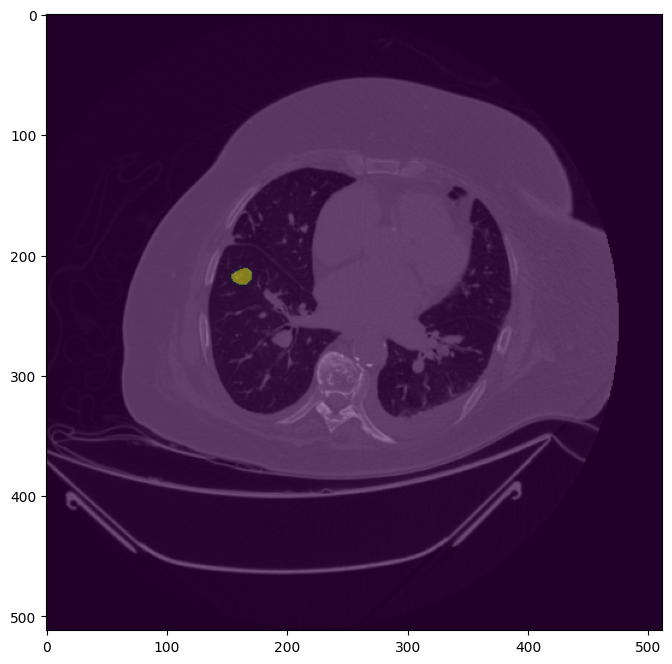

In [31]:
fig = plt.figure(figsize=(10,8))
plt.imshow(sample_ct[..., 54], cmap="gray")
plt.imshow(sample_infection_mask[..., 54], cmap="viridis", alpha=0.5)

(array([[502.,   3.,   2., ...,   0.,   0.,   0.],
        [498.,   7.,   1., ...,   0.,   0.,   0.],
        [494.,  10.,   3., ...,   0.,   0.,   0.],
        ...,
        [512.,   0.,   0., ...,   0.,   0.,   0.],
        [512.,   0.,   0., ...,   0.,   0.,   0.],
        [512.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([-1024. ,  -812.5,  -601. ,  -389.5,  -178. ,    33.5,   245. ,
          456.5,   668. ,   879.5,  1091. ]),
 <a list of 512 BarContainer objects>)

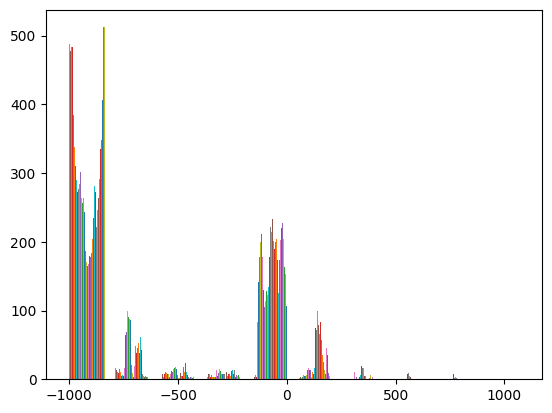

In [33]:
plt.hist(sample_ct[..., 54])

In [ ]:
Utils.plot_full_ct_scan(sample_ct)

# General Overview:

- 120 Study UIDs but 110 folders
- 229 SeriesInstance
- In the processed META 